# Halpha Emitters S-PLUS

In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
import matplotlib.pyplot as plt
from itertools import combinations
import umap.umap_ as umap
import seaborn as sns; sns.set()
sns.set_theme(style="ticks")

2025-01-27 17:28:18.600585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 17:28:18.668449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 17:28:18.998789: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 17:28:19.733149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 17:28:21.428136: W tensorflow/compiler/tf2

In [2]:
combined_df = pd.read_csv("../Ha-emitters/Halpha_Mine_PerField_total-unique_wise.csv")
combined_df

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,0000,0,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,0000,1,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,hh00,0,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,0000,0,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,0000,0,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,b'STRIPE82-0157',b'iDR4_3_STRIPE82-0157_0016873',349.808612,-0.962720,7268.3916,3780.7950,0.000391,1.049551,8.169368e-07,3.894912,...,0000,0,0nnn,ABUU,-127.0,811.0,-1330.0,808.0,NaN,0.073261
3169,b'STRIPE82-0158',b'iDR4_3_STRIPE82-0158_0009177',350.254869,0.323001,4347.6445,3032.8470,0.000335,0.986151,6.768905e-07,4.712428,...,0000,0,11nn,AABC,86.0,287.0,-678.0,293.0,NaN,0.122334
3170,b'STRIPE82-0162',b'iDR4_3_STRIPE82-0162_0018498',352.418578,0.670626,8739.1020,5308.4004,0.000349,1.035019,6.068673e-07,3.826304,...,0000,0,0nnn,ABUU,475.0,471.0,141.0,482.0,0.700,0.797824
3171,b'STRIPE82-0163',b'iDR4_3_STRIPE82-0163_0014886',354.578466,-0.927664,3879.0051,4010.2715,0.000404,1.171372,4.901620e-07,4.799046,...,0000,0,0nnn,ABUU,451.0,891.0,-856.0,897.0,NaN,0.562681


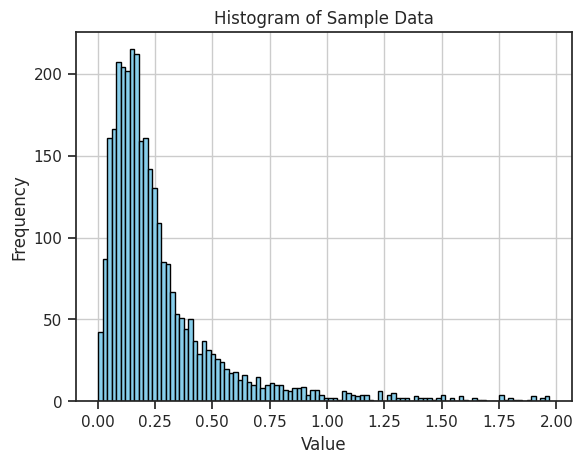

In [3]:
# See the distance of the SPLUS nad WISE source
# Plotting the histogram
plt.hist(combined_df["angDist"], bins=100, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [4]:
for columns in combined_df.columns:
    print(columns)

Field
ID
RA
DEC
X
Y
FWHM
FWHM_n
ISOarea
KRON_RADIUS
MU_MAX_INST
PETRO_RADIUS
SEX_FLAGS_DET
SEX_NUMBER_DET
CLASS_STAR
s2n_DET_PStotal
THETA
ELLIPTICITY
ELONGATION
FLUX_RADIUS_20
FLUX_RADIUS_50
FLUX_RADIUS_70
FLUX_RADIUS_90
s2n_r_PStotal
s2n_J0660_PStotal
s2n_i_PStotal
FWHM_r
FWHM_n_r
FWHM_J0660
FWHM_n_J0660
FWHM_i
FWHM_n_i
SEX_FLAGS_r
SEX_FLAGS_J0660
SEX_FLAGS_i
CLASS_STAR_r
CLASS_STAR_J0660
CLASS_STAR_i
r_PStotal
e_r_PStotal
g_PStotal
e_g_PStotal
i_PStotal
e_i_PStotal
u_PStotal
e_u_PStotal
z_PStotal
e_z_PStotal
J0378_PStotal
e_J0378_PStotal
J0395_PStotal
e_J0395_PStotal
J0410_PStotal
e_J0410_PStotal
J0430_PStotal
e_J0430_PStotal
J0515_PStotal
e_J0515_PStotal
J0660_PStotal
e_J0660_PStotal
J0861_PStotal
e_J0861_PStotal
r_psf
e_r_psf
g_psf
e_g_psf
i_psf
e_i_psf
u_psf
e_u_psf
z_psf
e_z_psf
J0378_psf
e_J0378_psf
J0395_psf
e_J0395_psf
J0410_psf
e_J0410_psf
J0430_psf
e_J0430_psf
J0515_psf
e_J0515_psf
J0660_psf
e_J0660_psf
J0861_psf
e_J0861_psf
AllWISE
RAJ2000
DEJ2000
eeMaj
eeMin
eePA
W1mag
W2

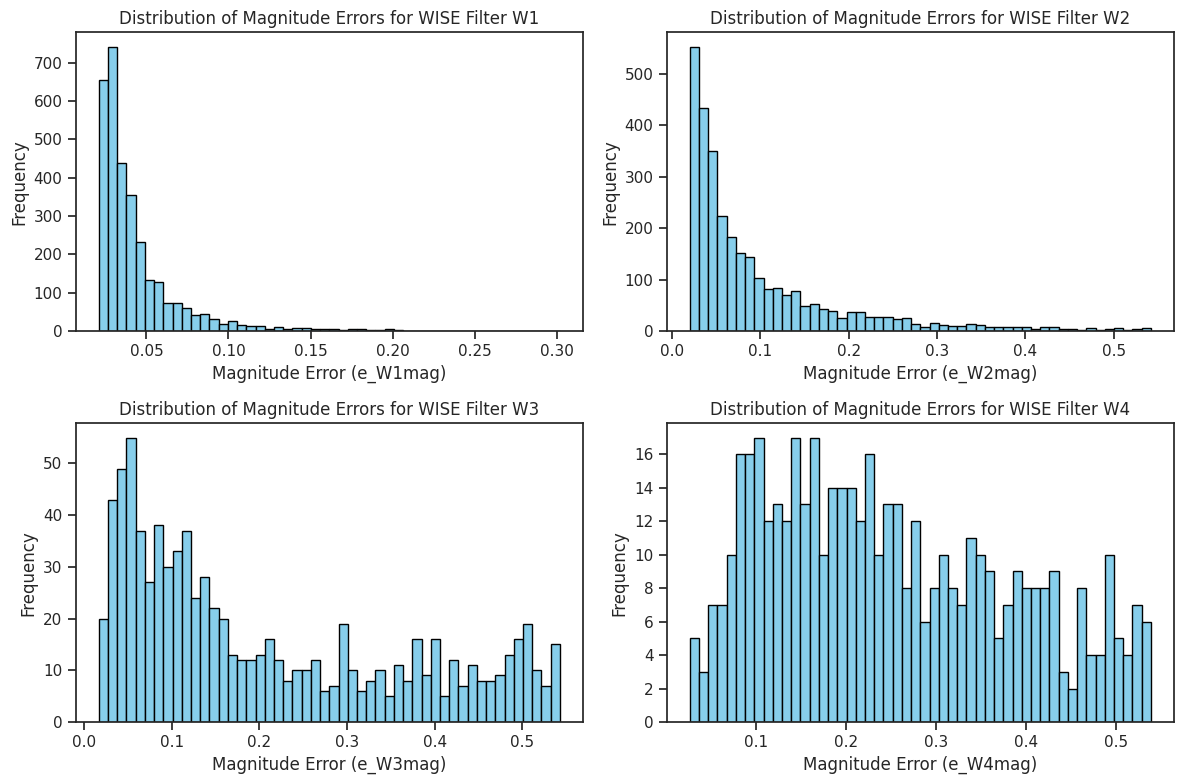

In [5]:
# Extract magnitude errors for WISE filters W1, W2, W3, W4
magnitude_errors_w1 = combined_df["e_W1mag"]
magnitude_errors_w2 = combined_df["e_W2mag"]
magnitude_errors_w3 = combined_df["e_W3mag"]
magnitude_errors_w4 = combined_df["e_W4mag"]

# Create subplots for each histogram
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for e_W1mag
axs[0, 0].hist(magnitude_errors_w1, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Magnitude Errors for WISE Filter W1')
axs[0, 0].set_xlabel('Magnitude Error (e_W1mag)')
axs[0, 0].set_ylabel('Frequency')

# Plot histogram for e_W2mag
axs[0, 1].hist(magnitude_errors_w2, bins=50, color='skyblue', edgecolor='black')
axs[0, 1].set_title('Distribution of Magnitude Errors for WISE Filter W2')
axs[0, 1].set_xlabel('Magnitude Error (e_W2mag)')
axs[0, 1].set_ylabel('Frequency')

# Plot histogram for e_W3mag
axs[1, 0].hist(magnitude_errors_w3, bins=50, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Distribution of Magnitude Errors for WISE Filter W3')
axs[1, 0].set_xlabel('Magnitude Error (e_W3mag)')
axs[1, 0].set_ylabel('Frequency')

# Plot histogram for e_W4mag
axs[1, 1].hist(magnitude_errors_w4, bins=50, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Distribution of Magnitude Errors for WISE Filter W4')
axs[1, 1].set_xlabel('Magnitude Error (e_W4mag)')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [6]:
# Cleaned error

m_err_splus = (combined_df["e_r_PStotal"] <= 0.2) & (combined_df["e_g_PStotal"] <= 0.2) & \
        (combined_df["e_i_PStotal"] <= 0.2) & (combined_df["e_u_PStotal"] <= 0.2) & \
        (combined_df["e_J0378_PStotal"] <= 0.2) & (combined_df["e_J0395_PStotal"] <= 0.2) & \
        (combined_df["e_J0410_PStotal"] <= 0.2) & (combined_df["e_J0430_PStotal"] <= 0.2) & \
        (combined_df["e_J0515_PStotal"] <= 0.2) & (combined_df["e_J0660_PStotal"] <= 0.2) & \
        (combined_df["e_J0861_PStotal"] <= 0.2) & (combined_df["e_z_PStotal"] <= 0.2)

# Choose a threshold for the maximum allowed magnitude error
max_allowed_e_Wmag = 0.5  # Example threshold value

# Apply the threshold to filter the dataset

m_err_wise = (combined_df["e_W1mag"] <= max_allowed_e_Wmag) & \
              (combined_df["e_W2mag"] <= max_allowed_e_Wmag) 
        

mask_total = (m_err_splus & m_err_wise)

In [7]:
df_cleanErr = combined_df[mask_total]
len(df_cleanErr)

1910

In [8]:
#Selecting columns
columns = ["r_PStotal",
"g_PStotal",
"i_PStotal",
"u_PStotal",
"z_PStotal",
"J0378_PStotal",
"J0395_PStotal",
"J0410_PStotal",
"J0430_PStotal",
"J0515_PStotal",
"J0660_PStotal",
"J0861_PStotal"]

In [9]:
df_mag = df_cleanErr[columns]
df_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,14.816056,14.486720
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,12.990587,12.979302
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,14.003431,13.810323
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,14.518179,14.313604
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,15.035774,15.058778
...,...,...,...,...,...,...,...,...,...,...,...,...
3156,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,18.374134,18.431206
3159,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,18.828121,19.304344
3163,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,18.536316,18.690256
3165,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,18.574770,18.961899


## Creating the colors

In [10]:
# Generate all combinations of magnitude columns
color_index_pairs = list(combinations(df_mag, 2))
len(color_index_pairs)

66

In [11]:
def calculate_earnings(df, index_pairs):
    for index_pair in index_pairs:
        color_index_name = f"{index_pair[0]} - {index_pair[1]}"
        df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
    return df

In [12]:
df_colors_mag = calculate_earnings(df_mag, color_index_pairs)

/tmp/ipykernel_101910/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_101910/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, color_index_name] = df[index_pair[0]] - df[index_pair[1]]
/tmp/ipykernel_101910/262842159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [13]:
df_colors_mag

,r_PStotal,g_PStotal,i_PStotal,u_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,15.220734,16.171457,14.812934,18.507275,14.589712,17.930260,17.468056,16.697994,16.477058,15.688791,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,13.060103,13.233669,13.076601,14.610666,13.112734,13.971252,13.690886,13.328466,13.250656,13.034685,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,14.198063,14.808924,14.000414,16.387249,13.904016,16.096981,15.934842,15.441872,15.274127,14.653158,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,14.722768,15.341463,14.474484,17.200853,14.391745,16.875017,16.729393,16.043348,15.896696,15.205017,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,15.091292,15.484464,15.128340,16.868654,15.073277,16.484432,16.317368,15.829420,15.745643,15.084617,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,18.613853,18.923706,18.582360,19.189054,18.201460,18.717813,19.045317,18.990812,18.943542,18.894592,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3159,19.183268,19.569181,19.162075,19.583511,19.304626,19.427560,19.520920,19.572699,19.552536,19.575880,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3163,18.887234,19.338186,18.768139,19.316458,18.735937,19.276064,19.300495,19.505459,19.480364,19.251190,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3165,18.843254,19.378155,18.858511,20.356724,18.963207,20.255262,19.657982,19.757696,19.888134,19.199867,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


In [14]:
# Drop magnitudes
df_colors = df_colors_mag.drop(columns=columns)

In [15]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,J0410_PStotal - J0430_PStotal,J0410_PStotal - J0515_PStotal,J0410_PStotal - J0660_PStotal,J0410_PStotal - J0861_PStotal,J0430_PStotal - J0515_PStotal,J0430_PStotal - J0660_PStotal,J0430_PStotal - J0861_PStotal,J0515_PStotal - J0660_PStotal,J0515_PStotal - J0861_PStotal,J0660_PStotal - J0861_PStotal
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,0.220936,1.009203,1.881938,2.211274,0.788267,1.661002,1.990338,0.872735,1.202071,0.329336
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,0.077810,0.293781,0.337879,0.349164,0.215971,0.260069,0.271354,0.044098,0.055383,0.011285
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,0.167745,0.788714,1.438441,1.631549,0.620969,1.270696,1.463804,0.649727,0.842835,0.193108
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,0.146652,0.838331,1.525169,1.729744,0.691679,1.378517,1.583092,0.686838,0.891413,0.204575
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,0.083777,0.744803,0.793646,0.770642,0.661026,0.709869,0.686865,0.048843,0.025839,-0.023004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,-0.309853,0.031493,-0.575201,0.412393,-0.103960,-0.431464,-0.376959,-0.329689,-0.280739,0.239719,...,0.047270,0.096220,0.616678,0.559606,0.048950,0.569408,0.512336,0.520458,0.463386,-0.057072
3159,-0.385913,0.021193,-0.400243,-0.121358,-0.244292,-0.337652,-0.389431,-0.369268,-0.392612,0.355147,...,0.020163,-0.003181,0.744578,0.268355,-0.023344,0.724415,0.248192,0.747759,0.271536,-0.476223
3163,-0.450952,0.119095,-0.429224,0.151297,-0.388830,-0.413261,-0.618225,-0.593130,-0.363956,0.350918,...,0.025095,0.254269,0.969143,0.815203,0.229174,0.944048,0.790108,0.714874,0.560934,-0.153940
3165,-0.534901,-0.015257,-1.513470,-0.119953,-1.412008,-0.814728,-0.914442,-1.044880,-0.356613,0.268484,...,-0.130438,0.557829,1.182926,0.795797,0.688267,1.313364,0.926235,0.625097,0.237968,-0.387129


### Making the color using some WISE filters

In [16]:
# Calculate differences between W1 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W1_{col}'] = df_cleanErr["W1mag"] - df_cleanErr[col]

# Calculate differences between W2 and each magnitude
for col in ["r_PStotal", "g_PStotal", "i_PStotal", "u_PStotal", "z_PStotal"]:
    df_colors[f'diff_W2_{col}'] = df_cleanErr["W2mag"] - df_cleanErr[col]


In [17]:
# Calculate difference between W1 and W2
df_colors['diff_W1_W2'] = df_cleanErr['W1mag'] - df_cleanErr['W2mag']

In [18]:
for columns in df_colors.columns:
    print(columns)

r_PStotal - g_PStotal
r_PStotal - i_PStotal
r_PStotal - u_PStotal
r_PStotal - z_PStotal
r_PStotal - J0378_PStotal
r_PStotal - J0395_PStotal
r_PStotal - J0410_PStotal
r_PStotal - J0430_PStotal
r_PStotal - J0515_PStotal
r_PStotal - J0660_PStotal
r_PStotal - J0861_PStotal
g_PStotal - i_PStotal
g_PStotal - u_PStotal
g_PStotal - z_PStotal
g_PStotal - J0378_PStotal
g_PStotal - J0395_PStotal
g_PStotal - J0410_PStotal
g_PStotal - J0430_PStotal
g_PStotal - J0515_PStotal
g_PStotal - J0660_PStotal
g_PStotal - J0861_PStotal
i_PStotal - u_PStotal
i_PStotal - z_PStotal
i_PStotal - J0378_PStotal
i_PStotal - J0395_PStotal
i_PStotal - J0410_PStotal
i_PStotal - J0430_PStotal
i_PStotal - J0515_PStotal
i_PStotal - J0660_PStotal
i_PStotal - J0861_PStotal
u_PStotal - z_PStotal
u_PStotal - J0378_PStotal
u_PStotal - J0395_PStotal
u_PStotal - J0410_PStotal
u_PStotal - J0430_PStotal
u_PStotal - J0515_PStotal
u_PStotal - J0660_PStotal
u_PStotal - J0861_PStotal
z_PStotal - J0378_PStotal
z_PStotal - J0395_PStotal


In [19]:
df_colors

,r_PStotal - g_PStotal,r_PStotal - i_PStotal,r_PStotal - u_PStotal,r_PStotal - z_PStotal,r_PStotal - J0378_PStotal,r_PStotal - J0395_PStotal,r_PStotal - J0410_PStotal,r_PStotal - J0430_PStotal,r_PStotal - J0515_PStotal,r_PStotal - J0660_PStotal,...,diff_W1_g_PStotal,diff_W1_i_PStotal,diff_W1_u_PStotal,diff_W1_z_PStotal,diff_W2_r_PStotal,diff_W2_g_PStotal,diff_W2_i_PStotal,diff_W2_u_PStotal,diff_W2_z_PStotal,diff_W1_W2
0,-0.950723,0.407800,-3.286541,0.631022,-2.709526,-2.247322,-1.477260,-1.256324,-0.468057,0.404678,...,-3.450457,-2.091934,-5.786275,-1.868712,-2.496734,-3.447457,-2.088934,-5.783275,-1.865712,-0.003
1,-0.173566,-0.016498,-1.550563,-0.052631,-0.911149,-0.630783,-0.268363,-0.190553,0.025418,0.069516,...,-1.251669,-1.094601,-2.628666,-1.130734,-1.052103,-1.225669,-1.068601,-2.602666,-1.104734,-0.026
2,-0.610861,0.197649,-2.189186,0.294047,-1.898918,-1.736779,-1.243809,-1.076064,-0.455095,0.194632,...,-2.409924,-1.601414,-3.988249,-1.505016,-1.798063,-2.408924,-1.600414,-3.987249,-1.504016,-0.001
3,-0.618695,0.248284,-2.478085,0.331023,-2.152249,-2.006625,-1.320580,-1.173928,-0.482249,0.204589,...,-2.507463,-1.640484,-4.366853,-1.557745,-1.900768,-2.519463,-1.652484,-4.378853,-1.569745,0.012
4,-0.393172,-0.037048,-1.777362,0.018015,-1.393140,-1.226076,-0.738128,-0.654351,0.006675,0.055518,...,-1.763464,-1.407340,-3.147654,-1.352277,-1.302292,-1.695464,-1.339340,-3.079654,-1.284277,-0.068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,-0.309853,0.031493,-0.575201,0.412393,-0.103960,-0.431464,-0.376959,-0.329689,-0.280739,0.239719,...,-5.083706,-4.742360,-5.349054,-4.361460,-5.754853,-6.064706,-5.723360,-6.330054,-5.342460,0.981
3159,-0.385913,0.021193,-0.400243,-0.121358,-0.244292,-0.337652,-0.389431,-0.369268,-0.392612,0.355147,...,-3.795181,-3.388075,-3.809511,-3.530626,-4.910268,-5.296181,-4.889075,-5.310511,-5.031626,1.501
3163,-0.450952,0.119095,-0.429224,0.151297,-0.388830,-0.413261,-0.618225,-0.593130,-0.363956,0.350918,...,-3.508186,-2.938139,-3.486458,-2.905937,-4.305234,-4.756186,-4.186139,-4.734458,-4.153937,1.248
3165,-0.534901,-0.015257,-1.513470,-0.119953,-1.412008,-0.814728,-0.914442,-1.044880,-0.356613,0.268484,...,-3.919155,-3.399511,-4.897724,-3.504207,-4.933254,-5.468155,-4.948511,-6.446724,-5.053207,1.549


# Reduction dimensionality

In [20]:
# Standarized the data
X_stand = StandardScaler().fit_transform(df_colors)

In [21]:
# Split data into training and validation sets
X_train, X_val = train_test_split(X_stand, test_size=0.2, random_state=42)

In [22]:
# Define a range of number of components to try
n_components_range = [2, 3, 4, 5, 10, 20, 50]
n_neighbors_range = [5, 10, 15, 20, 30, 50, 70, 100]

# Initialize variables to store the best parameters
best_silhouette_score = -1
best_davies_bouldin_score = np.inf
best_num_components = None
best_n_neighbors = None
best_labels = None

In [23]:
# Loop over different numbers of components and neighbors
for num_components in n_components_range:
    for n_neighbors in n_neighbors_range:
        # Fit UMAP model
        reducer_ = umap.UMAP(n_neighbors=n_neighbors, n_components=num_components, random_state=42)
        X_train_trans = reducer_.fit_transform(X_train)

        # Cluster the transformed data using KMeans
        kmeans = KMeans(n_clusters=num_components, random_state=42)
        labels = kmeans.fit_predict(X_train_trans)

        # Evaluate performance using Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_train_trans, labels)
        davies_bouldin = davies_bouldin_score(X_train_trans, labels)
        print(f"Components: {num_components}, Neighbors: {n_neighbors}, Silhouette Score: {silhouette}, DB Index: {davies_bouldin}")

        # Update best parameters based on combined metrics
        if silhouette > best_silhouette_score and davies_bouldin < best_davies_bouldin_score:
            best_silhouette_score = silhouette
            best_davies_bouldin_score = davies_bouldin
            best_num_components = num_components
            best_n_neighbors = n_neighbors
            best_labels = labels

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Best Davies-Bouldin Index: {best_davies_bouldin_score}")
print(f"Best Number of Components: {best_num_components}")
print(f"Best Number of Neighbors: {best_n_neighbors}")

/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 5, Silhouette Score: 0.5767263770103455, DB Index: 0.7021625438725967


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 10, Silhouette Score: 0.7092211842536926, DB Index: 0.4013076838928795


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 15, Silhouette Score: 0.706308901309967, DB Index: 0.43892559823736554


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 20, Silhouette Score: 0.6733999252319336, DB Index: 0.46462396136869527


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 30, Silhouette Score: 0.7402428388595581, DB Index: 0.36925408616956007


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 50, Silhouette Score: 0.7806289196014404, DB Index: 0.3004874081445396


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 70, Silhouette Score: 0.7660259008407593, DB Index: 0.3055572414842843


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 2, Neighbors: 100, Silhouette Score: 0.8195050358772278, DB Index: 0.2296683792919361


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 5, Silhouette Score: 0.48339852690696716, DB Index: 0.7393004970053699


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 10, Silhouette Score: 0.5541118383407593, DB Index: 0.5889761194497208


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 15, Silhouette Score: 0.547078549861908, DB Index: 0.6024407380899526


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 20, Silhouette Score: 0.5696713328361511, DB Index: 0.5705642125553706


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 30, Silhouette Score: 0.5839982628822327, DB Index: 0.5499190734871512


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 50, Silhouette Score: 0.6040021777153015, DB Index: 0.5187563037460331


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 70, Silhouette Score: 0.6302947402000427, DB Index: 0.4741336562925314


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 3, Neighbors: 100, Silhouette Score: 0.6320911049842834, DB Index: 0.4740955701396068


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 5, Silhouette Score: 0.5324369072914124, DB Index: 0.6864595932173285


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 10, Silhouette Score: 0.4747576415538788, DB Index: 0.7245448787875035


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 15, Silhouette Score: 0.49411672353744507, DB Index: 0.7202814115421526


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 20, Silhouette Score: 0.5014658570289612, DB Index: 0.7050500142901092


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 30, Silhouette Score: 0.5186669230461121, DB Index: 0.633976226281994


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 50, Silhouette Score: 0.5584897398948669, DB Index: 0.6105122966742974


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 70, Silhouette Score: 0.5722160935401917, DB Index: 0.5946975359330475


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 4, Neighbors: 100, Silhouette Score: 0.5773091316223145, DB Index: 0.5807024931737089


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 5, Silhouette Score: 0.5805549025535583, DB Index: 0.4696541137693696


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 10, Silhouette Score: 0.4826938211917877, DB Index: 0.6492342676404087


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 15, Silhouette Score: 0.5152176022529602, DB Index: 0.5963615213765394


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 20, Silhouette Score: 0.5003977417945862, DB Index: 0.6166805348830857


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 30, Silhouette Score: 0.5895115733146667, DB Index: 0.4162881618692512


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 50, Silhouette Score: 0.5413457155227661, DB Index: 0.6426257119777955


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 70, Silhouette Score: 0.5167510509490967, DB Index: 0.5770395876356276


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 5, Neighbors: 100, Silhouette Score: 0.5392346382141113, DB Index: 0.6540883784819309


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 5, Silhouette Score: 0.5129828453063965, DB Index: 0.6291072686760024


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 10, Silhouette Score: 0.5408056974411011, DB Index: 0.5305599625645762


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 15, Silhouette Score: 0.5114096403121948, DB Index: 0.654454042002413


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 20, Silhouette Score: 0.5317542552947998, DB Index: 0.6212863356296153


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 30, Silhouette Score: 0.5247392654418945, DB Index: 0.6274097918572618


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 50, Silhouette Score: 0.5014244914054871, DB Index: 0.6735618225975812


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 70, Silhouette Score: 0.49671700596809387, DB Index: 0.6661388438327903


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 10, Neighbors: 100, Silhouette Score: 0.485140323638916, DB Index: 0.6914403670818331


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 5, Silhouette Score: 0.5042082071304321, DB Index: 0.636167112110458


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 10, Silhouette Score: 0.515231728553772, DB Index: 0.6976068673589555


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 15, Silhouette Score: 0.47385209798812866, DB Index: 0.7655000036500037


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 20, Silhouette Score: 0.4727077782154083, DB Index: 0.7397534162579682


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 30, Silhouette Score: 0.4400655925273895, DB Index: 0.7531984627837192


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 50, Silhouette Score: 0.42712000012397766, DB Index: 0.816302389130985


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 70, Silhouette Score: 0.4297058880329132, DB Index: 0.8002041162687231


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 20, Neighbors: 100, Silhouette Score: 0.45165443420410156, DB Index: 0.7325043006677767


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 5, Silhouette Score: 0.4441378116607666, DB Index: 0.7908968017767944


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 10, Silhouette Score: 0.4438192844390869, DB Index: 0.7959029687754955


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 15, Silhouette Score: 0.44865384697914124, DB Index: 0.7820261147242917


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 20, Silhouette Score: 0.4441065490245819, DB Index: 0.7667934564113675


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 30, Silhouette Score: 0.41732892394065857, DB Index: 0.8048587856302479


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 50, Silhouette Score: 0.4067143201828003, DB Index: 0.8676646476220274


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 70, Silhouette Score: 0.39541178941726685, DB Index: 0.8492109496111716


/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Components: 50, Neighbors: 100, Silhouette Score: 0.3714461326599121, DB Index: 0.9068195006170804
Best Silhouette Score: 0.8195050358772278
Best Davies-Bouldin Index: 0.2296683792919361
Best Number of Components: 2
Best Number of Neighbors: 100


#### Try UMAP

In [24]:
num_components = 2
reducer = umap.UMAP(n_neighbors=50, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                    n_components=num_components,  # min_samples=15, min_cluster_size=60
                    random_state=42)
X_trans = reducer.fit_transform(X_stand)

/home/luis/anaconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [25]:
# Calculate the variance of the original data points in the reduced space
original_variance = np.var(X_trans, axis=0)

# Calculate the explained variance ratio
explained_variance_ratio = original_variance / np.sum(original_variance)

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

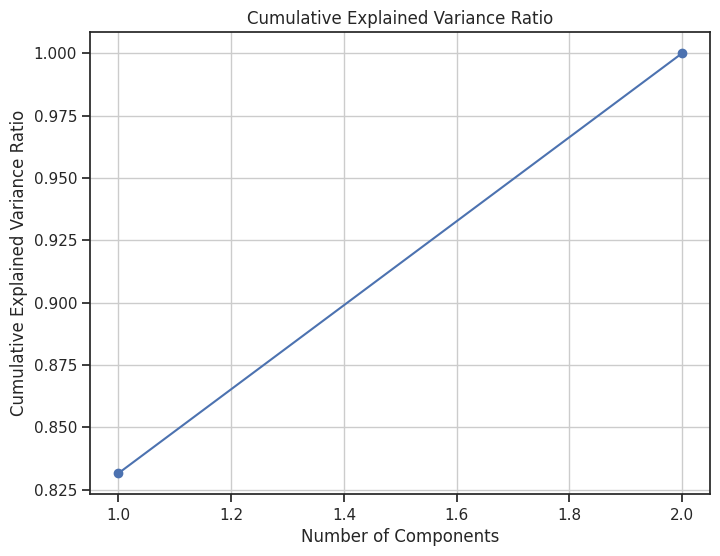

In [26]:
# Plot the cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [27]:
#umap_df = pd.DataFrame(X_trans, columns = ["PC1", "PC2", "PC3"])
# Create a DataFrame for PCA results
umap_columns = [f'PC{i}' for i in range(1, num_components + 1)]
umap_df = pd.DataFrame(data=X_trans, columns=umap_columns)
umap_df

,PC1,PC2
0,12.202629,2.276409
1,7.046351,8.736568
2,11.147096,4.682925
3,12.216504,4.232417
4,8.234937,8.145382
...,...,...
1905,-2.516111,7.034182
1906,-0.191933,9.604373
1907,-0.192143,8.461503
1908,-0.770747,8.319734


/tmp/ipykernel_101910/1329027073.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', 10))


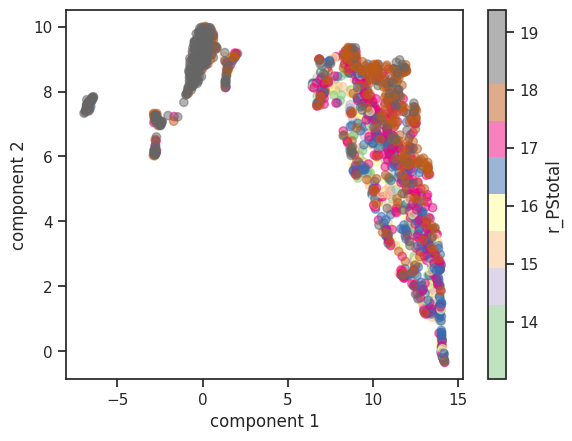

In [28]:
# Assuming umap_df is your DataFrame containing UMAP components and g_PStotal column
plt.scatter(umap_df["PC1"], umap_df["PC2"],
            c=df_cleanErr["r_PStotal"],  # Set color based on the values of "g_PStotal"
            alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(label='r_PStotal')  # Set the label of the color bar to 'g_PStotal'
plt.show()

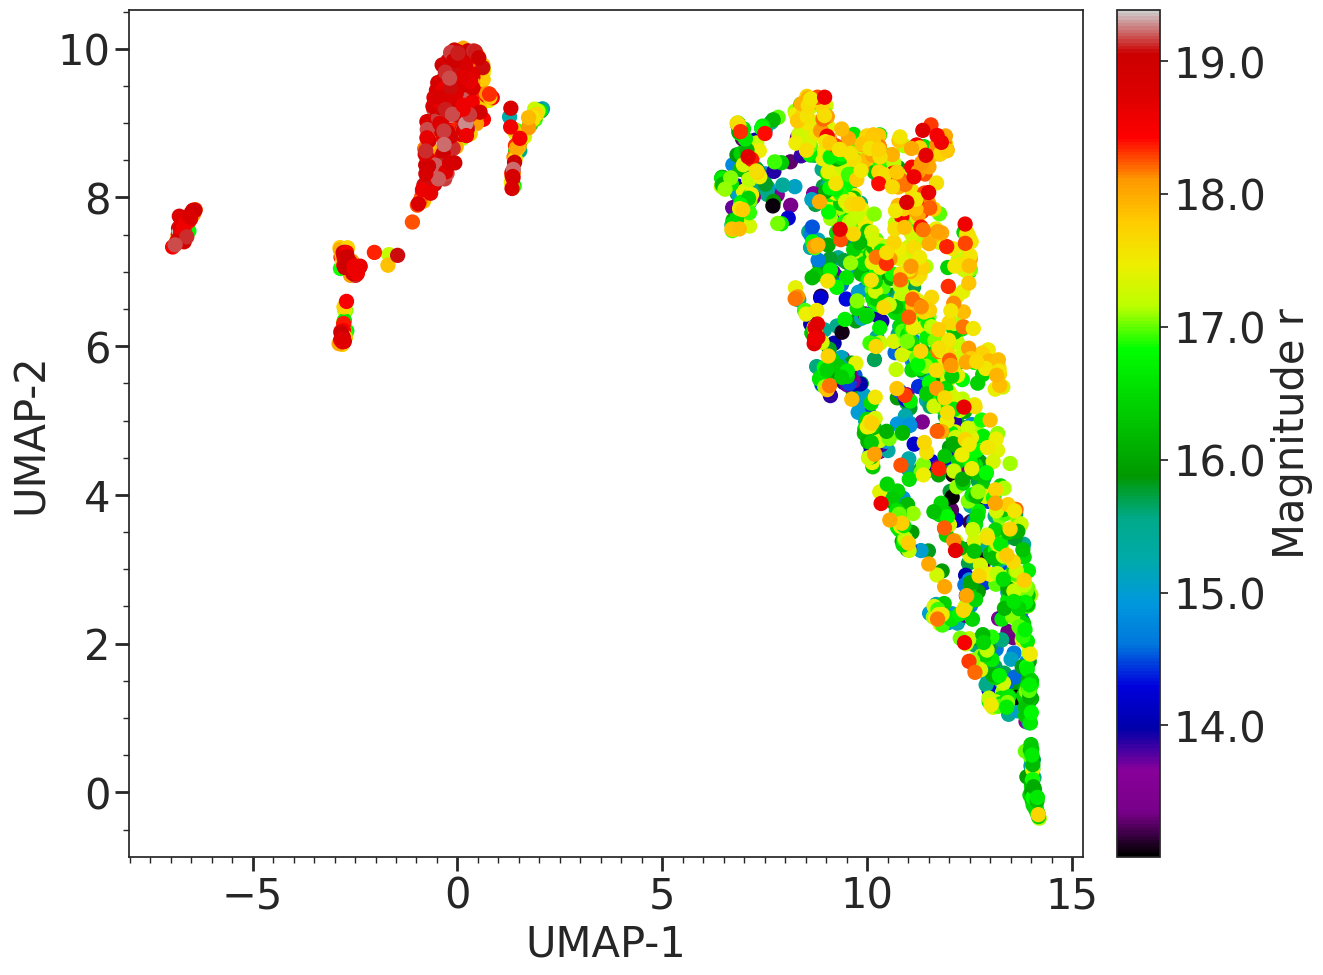

In [29]:
from matplotlib.ticker import MultipleLocator, NullFormatter

# Plotting
with sns.axes_style("ticks"):
    fig, ax = plt.subplots(figsize=(15, 11))
    plt.xlabel("UMAP-1", fontsize=30)
    plt.ylabel("UMAP-2", fontsize=30)
    plt.tick_params(axis='x', labelsize=30, width=2, length=10)  # Adjusting width of tick marks
    plt.tick_params(axis='y', labelsize=30, width=2, length=10)  # Adjusting width of tick marks

    # Create a scatter plot
    sc = ax.scatter(umap_df["PC1"], umap_df["PC2"], c=df_cleanErr["r_PStotal"], cmap="nipy_spectral", s=100)
    
    # Add minor tick locators without showing the minor ticks
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())

    # Add a colorbar with improved visibility
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, format='%.1f')
    cbar.set_label("Magnitude r", fontsize=30)  # Provide a label for the colorbar
    cbar.ax.tick_params(labelsize=30)  # Adjust the size of the tick labels

#plt.savefig("../Figs/umap_splus_disk_wise.pdf")

In [30]:
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=50, 
                             prediction_data=True, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=1, gen_min_span_tree=True)


In [31]:
clusterer.fit(X_trans)
labels = clusterer.labels_
len(labels)

1910

In [32]:
clusterer.metric

'euclidean'

In [33]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_cluster0 = list(labels).count(0)
n_cluster1 = list(labels).count(1)
n_cluster2 = list(labels).count(2)
n_cluster3 = list(labels).count(3)
n_noise_ = list(labels).count(-1)


In [34]:
# Print parameters
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of cluster points 0: %d' % n_cluster0)
print('Estimated number of cluster points 1: %d' % n_cluster1)
print('Estimated number of cluster points 2: %d' % n_cluster2)
print('Estimated number of cluster points 3: %d' % n_cluster3)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 5
Estimated number of cluster points 0: 1437
Estimated number of cluster points 1: 59
Estimated number of cluster points 2: 93
Estimated number of cluster points 3: 51
Estimated number of noise points: 1


<Axes: xlabel='PC1', ylabel='PC2'>

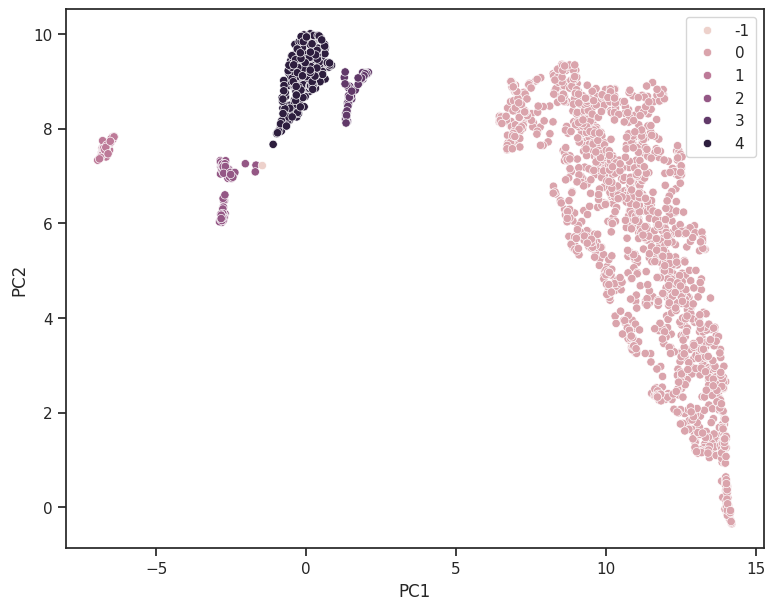

In [35]:
plt.figure(figsize=(9,7))
sns.scatterplot(x=umap_df["PC1"], y=umap_df["PC2"], 
                hue=labels,
                )

In [36]:
# Concatenat the original claen table with the umap results
df_cleanErr.reset_index(drop=True, inplace=True)
umap_df.reset_index(drop=True, inplace=True)
df_cleanErr_umap = pd.concat([df_cleanErr, umap_df], axis=1)
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist,PC1,PC2
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,87nn,AACU,182.0,57.0,64.0,59.0,0.115,0.129107,12.202629,2.276409
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,99nn,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308,7.046351,8.736568
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,99nn,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144,11.147096,4.682925
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,98nn,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241,12.216504,4.232417
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,01nn,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180,8.234937,8.145382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,000n,AAAB,94.0,170.0,-215.0,157.0,NaN,0.084062,-2.516111,7.034182
1906,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,00nn,AABU,360.0,456.0,139.0,471.0,NaN,0.232709,-0.191933,9.604373
1907,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,00nn,AACU,404.0,820.0,-89.0,866.0,NaN,0.227701,-0.192143,8.461503
1908,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,000n,AAAB,-237.0,316.0,-142.0,323.0,NaN,0.150187,-0.770747,8.319734


In [37]:
df_cleanErr_umap["Label"] = labels
df_cleanErr_umap

,Field,ID,RA,DEC,X,Y,FWHM,FWHM_n,ISOarea,KRON_RADIUS,...,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist,PC1,PC2,Label
0,b'HYDRA-0011',b'iDR4_3_HYDRA-0011_0001534',151.228065,-24.565881,2768.8430,1194.1807,0.000344,1.109519,7.119020e-06,2.708475,...,AACU,182.0,57.0,64.0,59.0,0.115,0.129107,12.202629,2.276409,0
1,b'HYDRA-0021',b'iDR4_3_HYDRA-0021_0019499',151.820602,-25.619486,1653.6090,3400.8994,0.000307,1.081890,2.490490e-05,2.232373,...,AABU,-10.0,47.0,-138.0,48.0,0.045,0.110308,7.046351,8.736568,0
2,b'HYDRA-0023',b'iDR4_3_HYDRA-0023_0021195',154.612704,-25.530006,3569.1528,3993.6829,0.000317,0.949352,1.283758e-05,2.532320,...,AACU,-16.0,54.0,-109.0,55.0,0.235,0.015144,11.147096,4.682925,0
3,b'HYDRA-0026',b'iDR4_3_HYDRA-0026_0046098',158.459389,-24.620632,8485.7730,9943.1000,0.000367,1.218677,7.749229e-06,2.742691,...,AAUU,6.0,70.0,55.0,78.0,0.249,0.270241,12.216504,4.232417,0
4,b'HYDRA-0031',b'iDR4_3_HYDRA-0031_0032774',150.917736,-26.667847,9368.1560,5633.4710,0.000384,1.078957,7.585842e-06,2.917582,...,AAUU,76.0,86.0,33.0,92.0,0.073,0.059180,8.234937,8.145382,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,b'STRIPE82-0132',b'iDR4_3_STRIPE82-0132_0011586',331.997487,0.289613,3249.1740,2814.3223,0.000363,1.000263,1.213735e-06,4.081015,...,AAAB,94.0,170.0,-215.0,157.0,NaN,0.084062,-2.516111,7.034182,2
1906,b'STRIPE82-0142',b'iDR4_3_STRIPE82-0142_0014029',339.139727,0.448016,2885.1482,3851.2144,0.000379,1.013615,6.535494e-07,4.638296,...,AABU,360.0,456.0,139.0,471.0,NaN,0.232709,-0.191933,9.604373,4
1907,b'STRIPE82-0147',b'iDR4_3_STRIPE82-0147_0003349',343.495206,-1.289140,2208.1868,1643.8495,0.000305,0.945969,7.469136e-07,3.516137,...,AACU,404.0,820.0,-89.0,866.0,NaN,0.227701,-0.192143,8.461503,4
1908,b'STRIPE82-0151',b'iDR4_3_STRIPE82-0151_0033785',346.434130,-0.425545,1524.9784,7296.7880,0.000348,0.984726,6.535494e-07,3.597043,...,AAAB,-237.0,316.0,-142.0,323.0,NaN,0.150187,-0.770747,8.319734,4


In [38]:
# Group the data based on the "Label" column
grouped_data = df_cleanErr_umap.groupby("Label")

In [39]:
# Define the directory where you want to save the CSV files
directory = '../Class_wise_main_unique_100neighbor/'

In [40]:
# Iterate over each group
for label, group_df in grouped_data:
    if label == -1:  # Noise points
        filename = f'Halpha_emitter_noise.csv'
    else:
        filename = f'Halpha_emitter_group{label}.csv'
    group_df.to_csv(directory + filename, index=False)